In [1]:
%matplotlib inline


# Gradient flows in 1D

Let's showcase the properties of **kernel MMDs**, **Hausdorff**
and **Sinkhorn** divergences on a simple toy problem:
the registration of an interval onto another.


## Setup



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity  # display as density curves
import time

import torch
from geomloss import SamplesLoss

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

### Display routine



In [3]:
t_plot = np.linspace(-0.1, 1.1, 1000)[:, np.newaxis]


def display_samples(ax, x, color):
    """Displays samples on the unit interval using a density curve."""
    kde = KernelDensity(kernel="gaussian", bandwidth=0.005).fit(x.data.cpu().numpy())
    dens = np.exp(kde.score_samples(t_plot))
    dens[0] = 0
    dens[-1] = 0
    ax.fill(t_plot, dens, color=color)

### Dataset

Our source and target samples are drawn from intervals of the real line
and define discrete probability measures:

\begin{align}\alpha ~=~ \frac{1}{N}\sum_{i=1}^N \delta_{x_i}, ~~~
  \beta  ~=~ \frac{1}{M}\sum_{j=1}^M \delta_{y_j}.\end{align}



In [4]:
N, M = (50, 50) if not use_cuda else (10000, 10000)

t_i = torch.linspace(0, 1, N).type(dtype).view(-1, 1)
t_j = torch.linspace(0, 1, M).type(dtype).view(-1, 1)

X_i, Y_j = 0.2 * t_i, 0.4 * t_j + 0.6

### Wasserstein gradient flow

To study the influence of the $\text{Loss}$ function in measure-fitting
applications, we perform gradient descent on the positions
$x_i$ of the samples that make up $\alpha$
as we minimize the cost $\text{Loss}(\alpha,\beta)$.
This procedure can be understood as a discrete (Lagrangian)
[Wasserstein gradient flow](https://arxiv.org/abs/1609.03890)
and as a "model-free" machine learning program, where
we optimize directly on the samples' locations.



In [5]:
def gradient_flow(loss, lr=0.01):
    """Flows along the gradient of the cost function, using a simple Euler scheme.

    Parameters:
        loss ((x_i,y_j) -> torch float number):
            Real-valued loss function.
        lr (float, default = .025):
            Learning rate, i.e. time step.
    """

    # Parameters for the gradient descent
    Nsteps = int(5 / lr) + 1
    display_its = [int(t / lr) for t in [0, 0.25, 0.50, 1.0, 2.0, 5.0]]

    # Make sure that we won't modify the reference samples
    x_i, y_j = X_i.clone(), Y_j.clone()

    # We're going to perform gradient descent on Loss(α, β)
    # wrt. the positions x_i of the diracs masses that make up α:
    x_i.requires_grad = True

    t_0 = time.time()
    plt.figure(figsize=(12, 8))
    k = 1
    for i in range(Nsteps):  # Euler scheme ===============
        # Compute cost and gradient
        L_αβ = loss(x_i, y_j)
        [g] = torch.autograd.grad(L_αβ, [x_i])

        if i in display_its:  # display
            ax = plt.subplot(2, 3, k)
            k = k + 1

            display_samples(ax, y_j, (0.55, 0.55, 0.95))
            display_samples(ax, x_i, (0.95, 0.55, 0.55))

            ax.set_title("t = {:1.2f}".format(lr * i))
            plt.axis([-0.1, 1.1, -0.1, 5.5])
            plt.xticks([], [])
            plt.yticks([], [])
            plt.tight_layout()

        # in-place modification of the tensor's values
        x_i.data -= lr * len(x_i) * g
    plt.title(
        "t = {:1.2f}, elapsed time: {:.2f}s/it".format(
            lr * i, (time.time() - t_0) / Nsteps
        )
    )

## Kernel norms, MMDs

### Gaussian MMD

The smooth Gaussian kernel
$k(x,y) = \exp(-\|x-y\|^2/2\sigma^2)$
is blind to details which are smaller than the blurring scale $\sigma$:
its gradient stops being informative when $\alpha$
and $\beta$ become equal "up to the high frequencies".



[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula c*Exp(-1/2*(a-b)**2) with a=Var(0,1,0), b=Var(1,1,1), c=Var(2,1,1) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula -(((d*c)*(a-b))*Exp(-1/2*(a-b)**2)) with a=Var(0,1,0), b=Var(1,1,1), c=Var(2,1,1), d=Var(3,1,0) ... OK


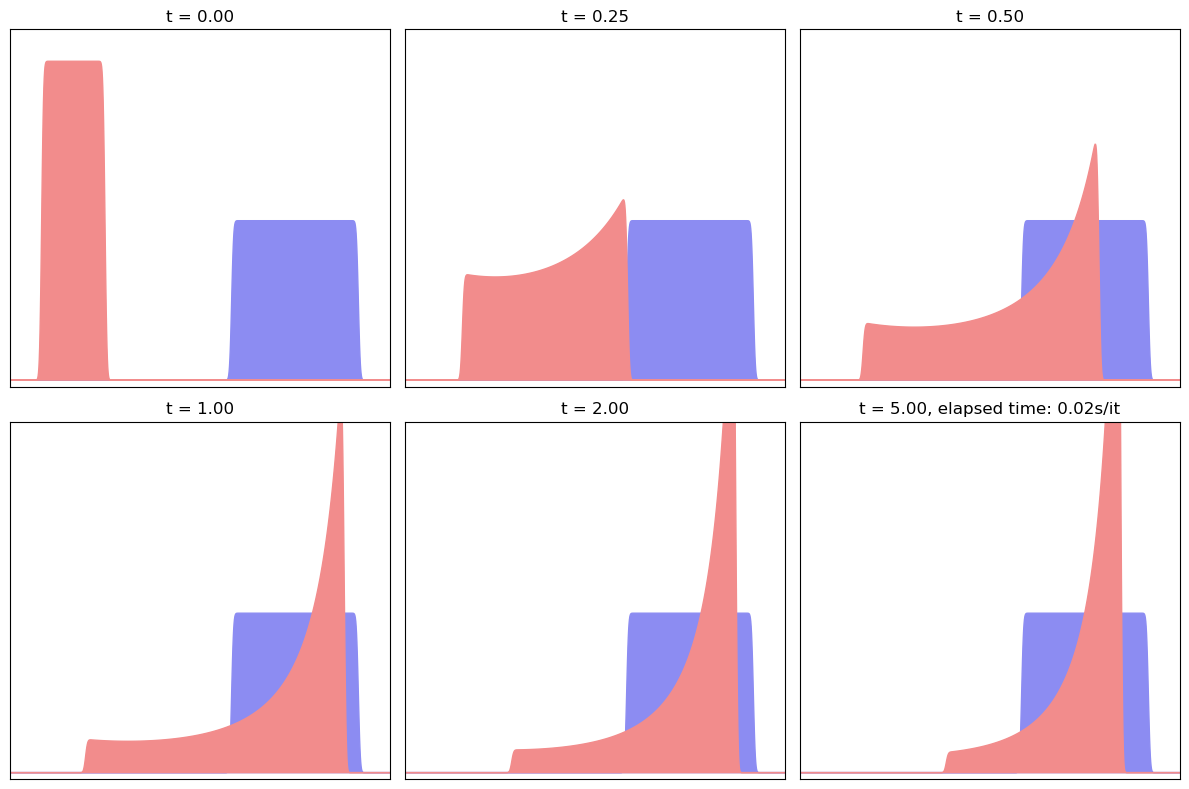

In [6]:
gradient_flow(SamplesLoss("gaussian", blur=0.5))

On the other hand, if the radius $\sigma$
of the kernel is too small, particles $x_i$
won't be attracted to the target, and may **spread out**
to minimize the auto-correlation term
$\tfrac{1}{2}\langle \alpha, k\star\alpha\rangle$.



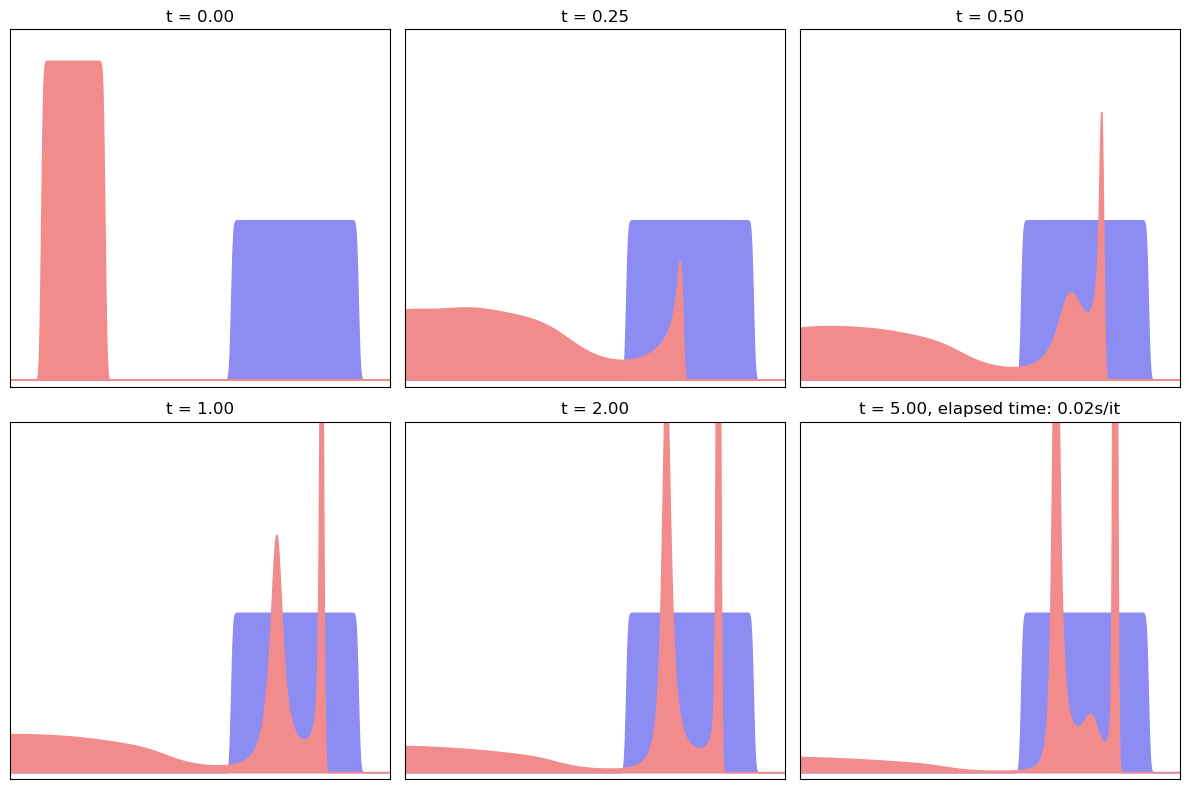

In [7]:
gradient_flow(SamplesLoss("gaussian", blur=0.1))

### Laplacian MMD

The pointy exponential kernel
$k(x,y) = \exp(-\|x-y\|/\sigma)$
tends to provide a better fit, but tends to zero at infinity
and is still very prone to **screening artifacts**.



[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula c*Exp(-Sqrt((a-b)**2)) with a=Var(0,1,0), b=Var(1,1,1), c=Var(2,1,1) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula -((((d*c)*(a-b))*Rsqrt((a-b)**2))*Exp(-Sqrt((a-b)**2))) with a=Var(0,1,0), b=Var(1,1,1), c=Var(2,1,1), d=Var(3,1,0) ... OK


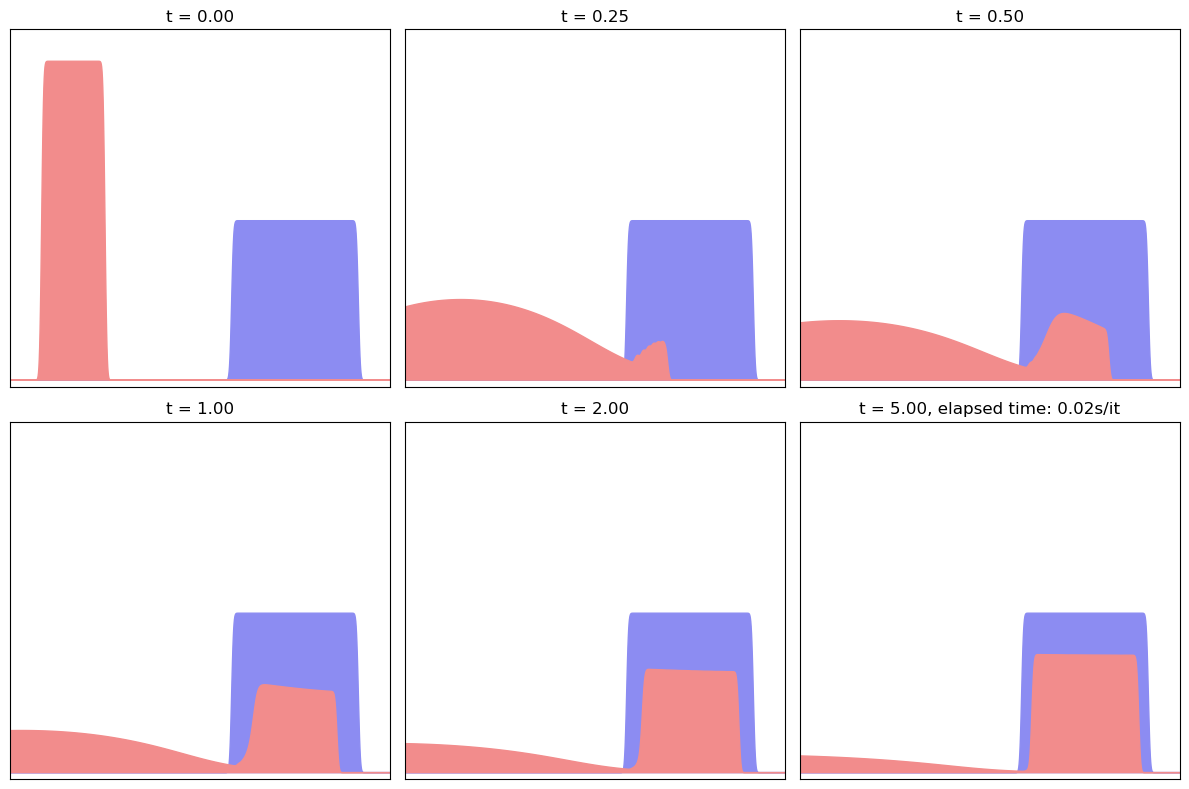

In [8]:
gradient_flow(SamplesLoss("laplacian", blur=0.1))

### Energy Distance MMD

The scale-equivariant kernel
$k(x,y)=-\|x-y\|$ provides a robust baseline:
the Energy Distance.



[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula -(Sqrt((a-b)**2)*c) with a=Var(0,1,0), b=Var(1,1,1), c=Var(2,1,1) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula -(((c*d)*(a-b))*Rsqrt((a-b)**2)) with a=Var(0,1,0), b=Var(1,1,1), c=Var(2,1,1), d=Var(3,1,0) ... OK


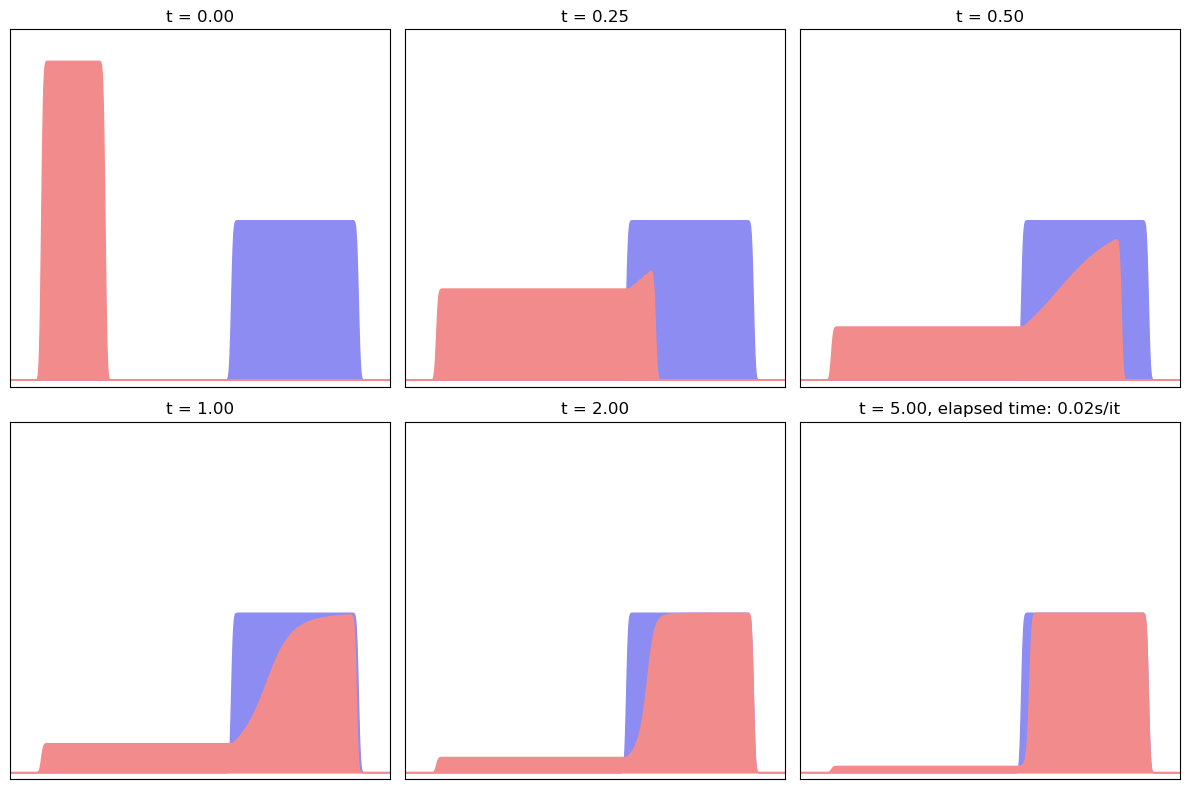

In [9]:
# sphinx_gallery_thumbnail_number = 4
gradient_flow(SamplesLoss("energy"))

## Sinkhorn divergence

(Unbiased) Sinkhorn divergences have recently been
introduced in the machine learning litterature,
and can be understood as modern iterations
of the classic [SoftAssign](https://en.wikipedia.org/wiki/Point_set_registration#Robust_point_matching) algorithm
from [economics](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.228.9750&rep=rep1&type=pdf) and
[computer vision](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.86.9769&rep=rep1&type=pdf).


### Wasserstein-1 distance

When ``p = 1``, the Sinkhorn divergence $\text{S}_\varepsilon$
interpolates between the Energy Distance (when $\varepsilon$ is large):



[KeOps] Generating code for Max_SumShiftExpWeight_Reduction reduction (with parameters 0) of formula [c-d*Sqrt((a-b)**2),1] with a=Var(0,1,0), b=Var(1,1,1), c=Var(2,1,1), d=Var(3,1,2) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula -((((d*Extract(e,1,1))*(a-b))*Rsqrt((a-b)**2))*Exp((c-d*Sqrt((a-b)**2))-Extract(f,0,1))) with a=Var(0,1,0), b=Var(1,1,1), c=Var(2,1,1), d=Var(3,1,2), e=Var(4,2,0), f=Var(5,2,0) ... OK


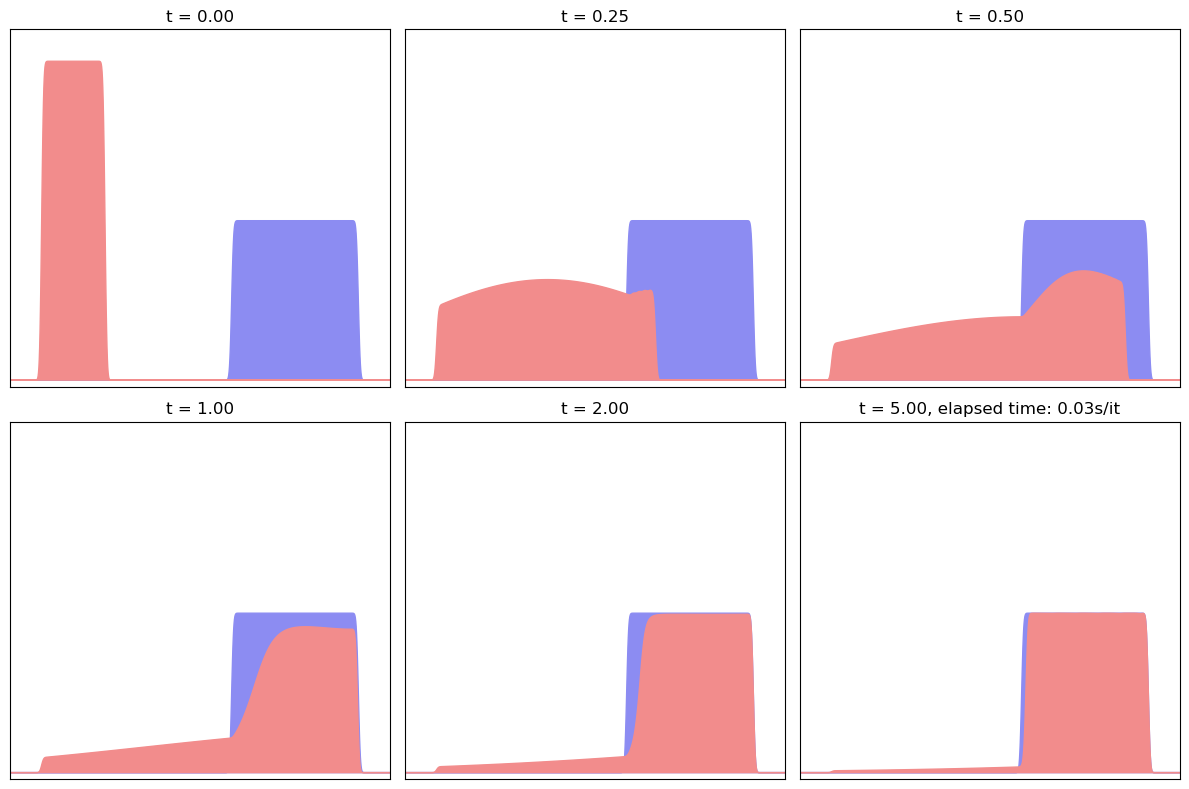

In [10]:
gradient_flow(SamplesLoss("sinkhorn", p=1, blur=1.0))

And the Earth-Mover's (Wassertein-1) distance:




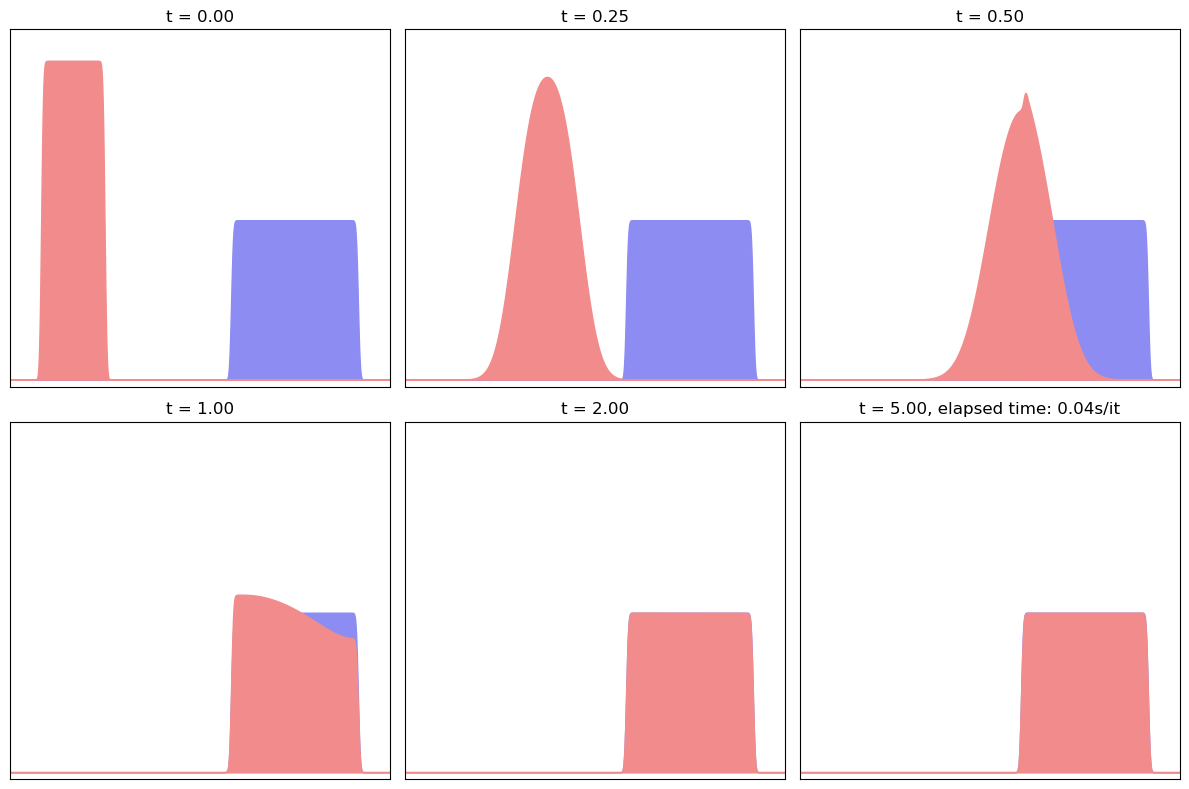

In [11]:
gradient_flow(SamplesLoss("sinkhorn", p=1, blur=0.01))

### Wasserstein-2 distance

When ``p = 2``, $\text{S}_\varepsilon$
interpolates between the degenerate kernel norm

\begin{align}\tfrac{1}{2}\| \alpha-\beta\|^2_{-\tfrac{1}{2}\|\cdot\|^2}
  ~=~ \tfrac{1}{2}\| \int x \text{d}\alpha(x)~-~\int y \text{d}\beta(y)\|^2,\end{align}

which only registers the means of both measures with each other
(when $\varepsilon$ is large):



[KeOps] Generating code for Max_SumShiftExpWeight_Reduction reduction (with parameters 0) of formula [c-1/2*(d*(a-b)**2),1] with a=Var(0,1,0), b=Var(1,1,1), c=Var(2,1,1), d=Var(3,1,2) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula -(((d*Extract(e,1,1))*(a-b))*Exp((c-1/2*(d*(a-b)**2))-Extract(f,0,1))) with a=Var(0,1,0), b=Var(1,1,1), c=Var(2,1,1), d=Var(3,1,2), e=Var(4,2,0), f=Var(5,2,0) ... OK


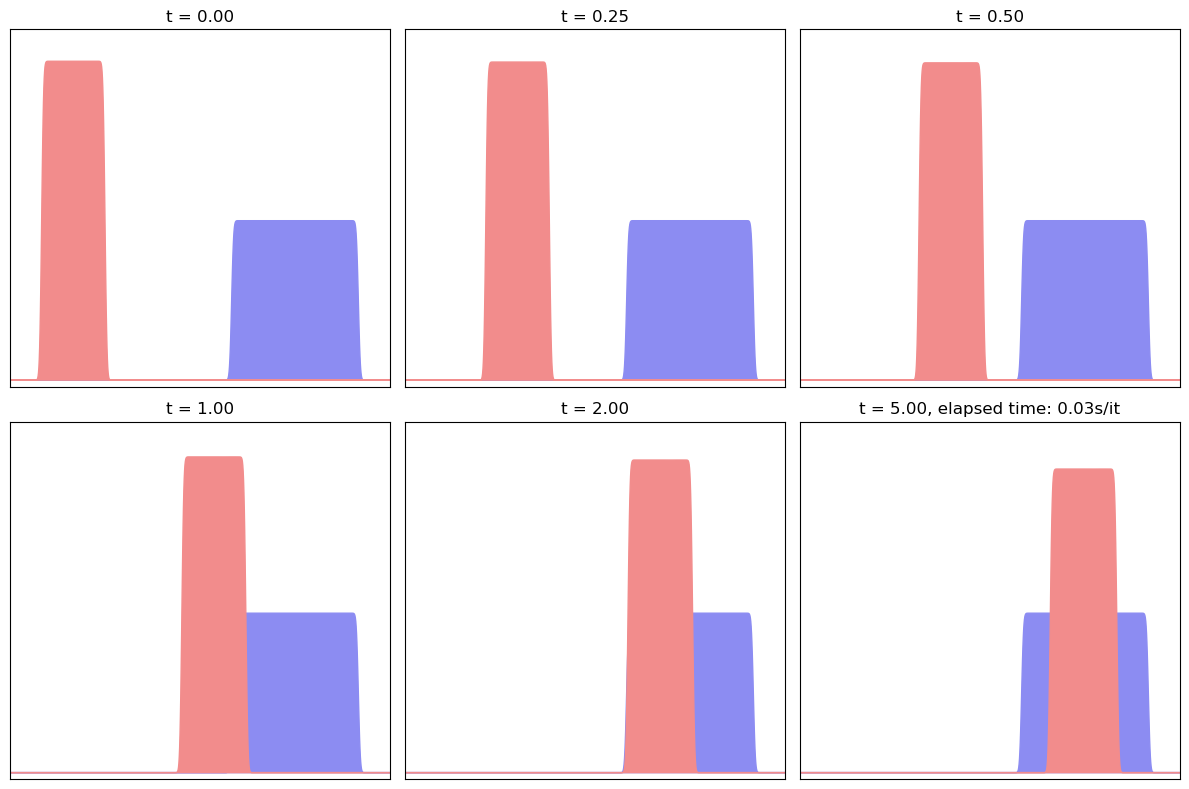

In [12]:
gradient_flow(SamplesLoss("sinkhorn", p=2, blur=1.0))

And the quadratic, Wasserstein-2 Optimal Transport
distance which has been studied so well by mathematicians
from the 80's onwards (when $\varepsilon$ is small):



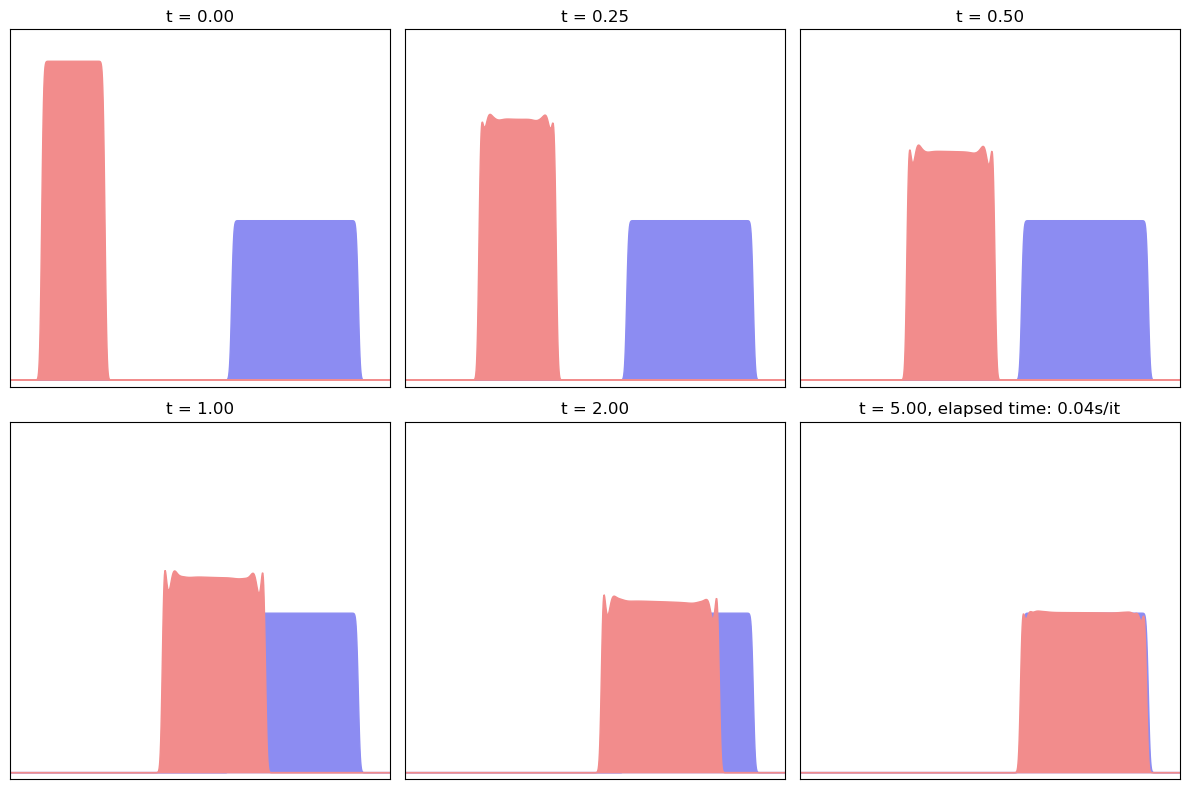

In [13]:
gradient_flow(SamplesLoss("sinkhorn", p=2, blur=0.01))

Introduced in 2016-2018, the *unbalanced*
setting (Gaussian-Hellinger, Wasserstein-Fisher-Rao, etc.)
provides a principled way of introducing a **threshold**
in Optimal Transport computations:
it allows you to introduce **laziness** in the transportation problem
by replacing distance fields $\|x-y\|$
with a robustified analogous $\rho\cdot( 1 - e^{-\|x-y\|/\rho} )$,
whose gradient saturates beyond a given **reach**, $\rho$
- at least, that's the idea.

In real-life applications, this tunable parameter could allow
you to be a little bit more **robust to outliers**!



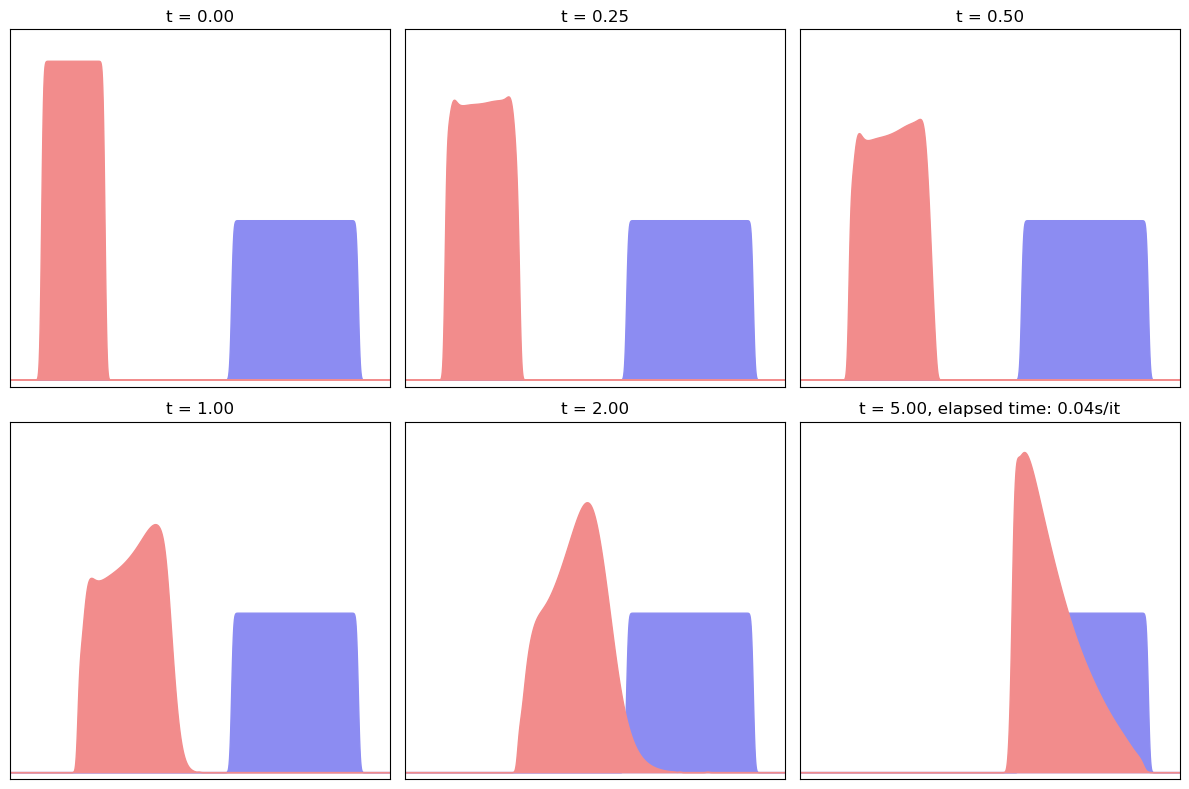

In [14]:
gradient_flow(SamplesLoss("sinkhorn", p=2, blur=0.01, reach=0.3))

plt.show()